# IVS R-diff quicklook

Minimal notebook that mirrors the MATLAB `Plot_script_sample.m` workflow: load two IVS skill files, compute D2–D1 R differences, plot on the M36 EASE grid, and save a `.mat` file with `Rdiff_vector`, `lats`, and `lons`.


In [11]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat, savemat

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap

# repo utilities
def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / '.git').exists():
            return p
    return start

here = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
repo_root = find_repo_root(here)
sys.path.append(str(repo_root / 'common' / 'python' / 'plotting'))
sys.path.append(str(repo_root / 'common' / 'python' / 'io'))
sys.path.append(str(repo_root / 'projects' / 'matlab2python' / 'shared' / 'python'))
sys.path.append('../util/shared/python/')

from geospatial_plotting import REGION_BOUNDS, load_ease_grid, build_ease_grid_mapping

DATA_DIR = Path('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/ASCAT_obs_var')

# Hardwired repo path so the EASE utility is available
REPO_ROOT = Path("/Users/amfox/Desktop/geosldas-analysis/projects/matlab2python")
sys.path.append(str(REPO_ROOT / "shared" / "python"))
from EASEv2 import EASEv2_ind2latlon  # noqa: E402


In [12]:
# Experiment configuration (two experiments, each with CNTL and DA)
data_dir = Path("/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/ASCAT_obs_var")

experiments = [
    {
        "name": "Bugfix_FP",
        "cntl": "OLv7_M36_MULTI_type_13_comb_fp_scaled_IVD_IVS_stats_lag2day_201504_202103",
        "da": "DAv7_M36_ASCAT_bugfix_IVD_IVS_stats_lag2day_201504_202103",
    },
    {
        "name": "ASC_DA_FP",
        "cntl": "OLv7_M36_MULTI_type_13_comb_fp_scaled_IVD_IVS_stats_lag2day_201504_202103",
        "da": "DAv7_M36_ASCAT_type_13_comb_fp_scaled_IVD_IVS_stats_lag2day_201504_202103",
    },
]

files = {
    f"{exp['name']}_cntl": data_dir / f"SMPL3_{exp['cntl']}.mat"
    for exp in experiments
}
files.update({
    f"{exp['name']}_da": data_dir / f"SMPL3_{exp['da']}.mat"
    for exp in experiments
})
files


{'Bugfix_FP_cntl': PosixPath('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/ASCAT_obs_var/SMPL3_OLv7_M36_MULTI_type_13_comb_fp_scaled_IVD_IVS_stats_lag2day_201504_202103.mat'),
 'ASC_DA_FP_cntl': PosixPath('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/ASCAT_obs_var/SMPL3_OLv7_M36_MULTI_type_13_comb_fp_scaled_IVD_IVS_stats_lag2day_201504_202103.mat'),
 'Bugfix_FP_da': PosixPath('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/ASCAT_obs_var/SMPL3_DAv7_M36_ASCAT_bugfix_IVD_IVS_stats_lag2day_201504_202103.mat'),
 'ASC_DA_FP_da': PosixPath('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/ASCAT_obs_var/SMPL3_DAv7_M36_ASCAT_type_13_comb_fp_scaled_IVD_IVS_stats_lag2day_201504_202103.mat')}

In [13]:
def _as_vector(mat_array: np.ndarray) -> np.ndarray:
    return np.asarray(mat_array, dtype=float).ravel(order="F")


def load_skill_file(path: Path) -> tuple[np.ndarray, np.ndarray]:
    data = loadmat(path, simplify_cells=True)
    return _as_vector(data["R2_ivs_obs"]), _as_vector(data["R2_ivs_mod"])


def compute_R(path: Path) -> np.ndarray:
    R2_obs, R2_mod = load_skill_file(path)
    R_mod = np.sqrt(R2_mod)
    R_obs = np.sqrt(R2_obs)
    R_mod[R_mod < 0.1] = np.nan
    R_obs[R_obs < 0.1] = np.nan
    R_mod[np.isnan(R_obs)] = np.nan
    return R_mod


R_fields = {key: compute_R(path) for key, path in files.items()}
R_fields


{'Bugfix_FP_cntl': array([nan, nan, nan, ..., nan, nan, nan]),
 'ASC_DA_FP_cntl': array([nan, nan, nan, ..., nan, nan, nan]),
 'Bugfix_FP_da': array([nan, nan, nan, ..., nan, nan, nan]),
 'ASC_DA_FP_da': array([nan, nan, nan, ..., nan, nan, nan])}

In [14]:
# Build EASEv2 M36 lat/lon grids using bundled EASE files
lats_ease, lons_ease = load_ease_grid()
lats_row = lats_ease[:, 1]
lons_col = lons_ease[1, :]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)

# Flatten for mapping input
lon_flat = lon_grid.ravel(order="C")
lat_flat = lat_grid.ravel(order="C")


def to_grid(values: np.ndarray) -> np.ndarray:
    map_array = np.column_stack([values, lon_flat, lat_flat])
    return build_ease_grid_mapping(map_array, lats_row, lons_col)


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_81563/1826905505.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  diff_cmap = get_cmap("RdBu", len(diff_edges) - 1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_81563/1826905505.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  delta_cmap = get_cmap("RdBu", len(delta_edges) - 1)


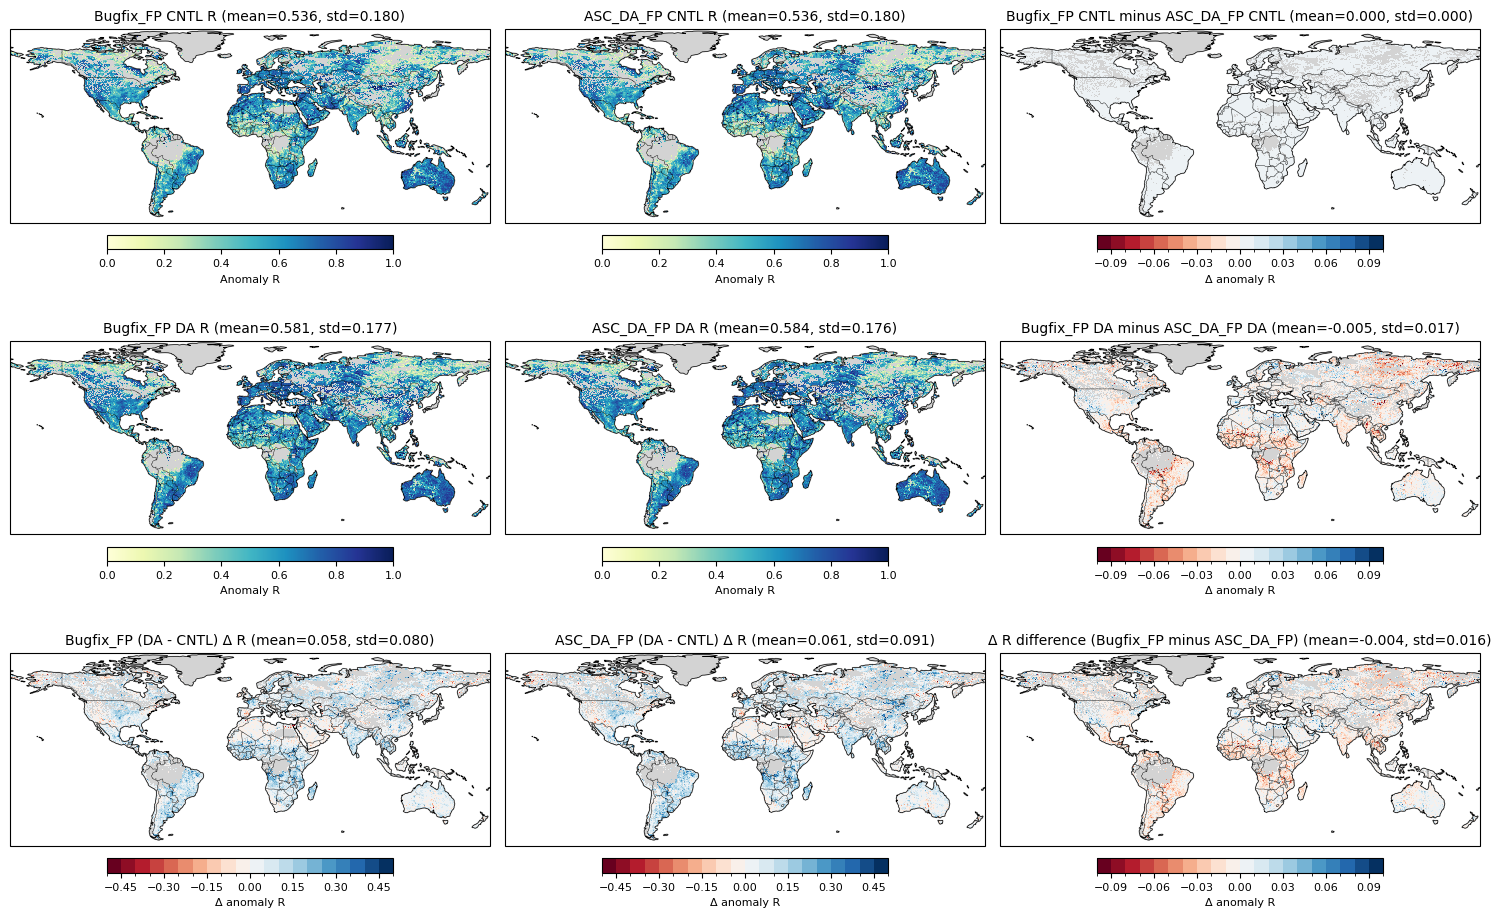

In [22]:
# 3x3 panel: CNTL row, DA row, (DA-CNTL) row
exp_a, exp_b = experiments

cntl_a = R_fields[f"{exp_a['name']}_cntl"]
cntl_b = R_fields[f"{exp_b['name']}_cntl"]

da_a = R_fields[f"{exp_a['name']}_da"]
da_b = R_fields[f"{exp_b['name']}_da"]

# Differences: first two rows now A minus B (reversed from prior)
cntl_diff = cntl_a - cntl_b
da_diff = da_a - da_b

da_minus_cntl_a = da_a - cntl_a
da_minus_cntl_b = da_b - cntl_b
delta_diff = da_minus_cntl_a - da_minus_cntl_b

stats = {
    "cntl_a": (np.nanmean(cntl_a), np.nanstd(cntl_a)),
    "cntl_b": (np.nanmean(cntl_b), np.nanstd(cntl_b)),
    "cntl_diff": (np.nanmean(cntl_diff), np.nanstd(cntl_diff)),
    "da_a": (np.nanmean(da_a), np.nanstd(da_a)),
    "da_b": (np.nanmean(da_b), np.nanstd(da_b)),
    "da_diff": (np.nanmean(da_diff), np.nanstd(da_diff)),
    "delta_a": (np.nanmean(da_minus_cntl_a), np.nanstd(da_minus_cntl_a)),
    "delta_b": (np.nanmean(da_minus_cntl_b), np.nanstd(da_minus_cntl_b)),
    "delta_diff": (np.nanmean(delta_diff), np.nanstd(delta_diff)),
}

panels = {
    "cntl_a": to_grid(cntl_a),
    "cntl_b": to_grid(cntl_b),
    "cntl_diff": to_grid(cntl_diff),
    "da_a": to_grid(da_a),
    "da_b": to_grid(da_b),
    "da_diff": to_grid(da_diff),
    "delta_a": to_grid(da_minus_cntl_a),
    "delta_b": to_grid(da_minus_cntl_b),
    "delta_diff": to_grid(delta_diff),
}

fig, axes = plt.subplots(3, 3, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})

r_norm = plt.Normalize(0, 1)
r_cmap = "YlGnBu"
diff_edges = np.linspace(-0.1, 0.1, 21)
diff_cmap = get_cmap("RdBu", len(diff_edges) - 1)
diff_norm = BoundaryNorm(diff_edges, diff_cmap.N)
delta_edges = np.linspace(-0.5, 0.5, 21)
delta_cmap = get_cmap("RdBu", len(delta_edges) - 1)
delta_norm = BoundaryNorm(delta_edges, delta_cmap.N)

layout = [
    (0, 0, "cntl_a", f"{exp_a['name']} CNTL R", r_cmap, r_norm),
    (0, 1, "cntl_b", f"{exp_b['name']} CNTL R", r_cmap, r_norm),
    (0, 2, "cntl_diff", f"{exp_a['name']} CNTL minus {exp_b['name']} CNTL", diff_cmap, diff_norm),
    (1, 0, "da_a", f"{exp_a['name']} DA R", r_cmap, r_norm),
    (1, 1, "da_b", f"{exp_b['name']} DA R", r_cmap, r_norm),
    (1, 2, "da_diff", f"{exp_a['name']} DA minus {exp_b['name']} DA", diff_cmap, diff_norm),
    (2, 0, "delta_a", f"{exp_a['name']} (DA - CNTL) Δ R", delta_cmap, delta_norm),
    (2, 1, "delta_b", f"{exp_b['name']} (DA - CNTL) Δ R", delta_cmap, delta_norm),
    (2, 2, "delta_diff", f"Δ R difference ({exp_a['name']} minus {exp_b['name']})", diff_cmap, diff_norm),
]

for row, col, key, title, cmap, norm in layout:
    ax = axes[row, col]
    grid = panels[key]
    mesh = ax.pcolormesh(lon_grid, lat_grid, grid, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, color="lightgray", zorder=0)
    ax.set_extent(REGION_BOUNDS["global"], crs=ccrs.PlateCarree())
    mean_val, std_val = stats[key]
    ax.set_title(f"{title} (mean={mean_val:.3f}, std={std_val:.3f})", fontsize=10)
    ax.tick_params(labelbottom=False, labelleft=False)
    cbar = fig.colorbar(
        mesh,
        ax=ax,
        orientation="horizontal",
        fraction=0.046,
        pad=0.04,
    )
    cbar.set_label("Anomaly R" if norm is r_norm else "Δ anomaly R", fontsize=8)
    cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()


In [16]:
print('Minimum of Bugfix_FP_da excluding NaNs:', np.nanmin(R_fields['Bugfix_FP_da']))
print('Maximum of Bugfix_FP_da excluding NaNs:', np.nanmax(R_fields['Bugfix_FP_da']))

Minimum of Bugfix_FP_da excluding NaNs: 0.10004751031907502
Maximum of Bugfix_FP_da excluding NaNs: 1.0


In [ ]:
# 3x3 pcolormesh panels (CNTL vs DA and differences)
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

panel_order = [
    ('cntl_a', 'Bugfix_FP CNTL R'),
    ('cntl_b', 'ASC_DA_FP CNTL R'),
    ('cntl_diff', 'Bugfix_FP CNTL - ASC_DA_FP CNTL'),
    ('da_a', 'Bugfix_FP DA R'),
    ('da_b', 'ASC_DA_FP DA R'),
    ('da_diff', 'Bugfix_FP DA - ASC_DA_FP DA'),
    ('delta_a', 'Bugfix_FP DA - CNTL'),
    ('delta_b', 'ASC_DA_FP DA - CNTL'),
    ('delta_diff', '(Bugfix_FP DA-CNTL) - (ASC_DA_FP DA-CNTL)'),
]

fig, axes = plt.subplots(3, 3, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()

for ax, (key, title) in zip(axes, panel_order):
    data_grid = panels[key]
    # choose color limits
    if 'diff' in key:
        vmax = np.nanmax(np.abs(data_grid))
        vmax = max(vmax, 0.05)
        vmin = -vmax
        cmap = get_cmap('RdBu_r', 21)
        edges = np.linspace(vmin, vmax, 21)
    else:
        vmin, vmax = 0.0, max(np.nanmax(data_grid), 1.0)
        cmap = get_cmap('YlGnBu', 21)
        edges = np.linspace(vmin, vmax, 21)
    norm = BoundaryNorm(edges, cmap.N)
    pcm = ax.pcolormesh(lon_grid, lat_grid, data_grid, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=0)
    ax.set_global()
    ax.set_title(title, fontsize=10)
    ax.tick_params(labelsize=8)
    cbar = plt.colorbar(pcm, ax=ax, orientation='horizontal', pad=0.04, fraction=0.046)
    cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
